In [12]:
%load_ext autoreload
%autoreload 2
from targets.density_estimation_target import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


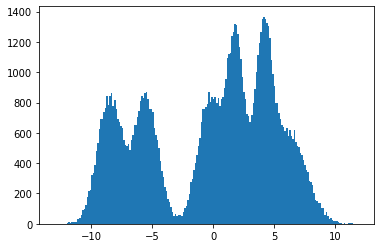

In [13]:
target = Dimension1()
data = target.sample(100000)
fig = plt.hist(data.numpy(), bins = 200)
plt.show()

In [14]:
import torch
from torch import nn
from torch.distributions import Categorical
from tqdm import tqdm

from models_dif.multivariate_normal_reference import MultivariateNormalReference
class LocationScaleFlow(nn.Module):
    def __init__(self, K, p):
        super().__init__()
        self.K = K
        self.p = p

        self.m = nn.Parameter(torch.randn(self.K, self.p))
        self.log_s = nn.Parameter(torch.zeros(self.K, self.p))

    def backward(self, z):
        desired_size = list(z.shape)
        desired_size.insert(-1, self.K)
        Z = z.unsqueeze(-2).expand(desired_size)
        return Z * torch.exp(self.log_s).expand_as(Z) + self.m.expand_as(Z)

    def forward(self, x):
        desired_size = list(x.shape)
        desired_size.insert(-1, self.K)
        X = x.unsqueeze(-2).expand(desired_size)
        return (X-self.m.expand_as(X))/torch.exp(self.log_s).expand_as(X)

    def log_det_J(self,x):
        return -self.log_s.sum(-1)
    
class SoftmaxWeight(nn.Module):
    def __init__(self, K, p, hidden_dimensions =[]):
        super().__init__()
        self.K = K
        self.p = p
        self.network_dimensions = [self.p] + hidden_dimensions + [self.K]
        network = []
        for h0, h1 in zip(self.network_dimensions, self.network_dimensions[1:]):
            network.extend([nn.Linear(h0, h1),nn.Tanh(),])
        network.pop()
        self.f = nn.Sequential(*network)

    def log_prob(self, z):
        unormalized_log_w = self.f.forward(z)
        return unormalized_log_w - torch.logsumexp(unormalized_log_w, dim=-1, keepdim=True)

class DIFDensityEstimator(nn.Module):
    def __init__(self, target_samples, K):
        super().__init__()
        self.target_samples = target_samples
        self.p = self.target_samples.shape[-1]
        self.K = K

        self.reference = MultivariateNormalReference(self.p)

        self.w = SoftmaxWeight(self.K, self.p, [])

        self.T = LocationScaleFlow(self.K, self.p)
        self.T.m = nn.Parameter(self.target_samples[torch.randint(low= 0, high = self.target_samples.shape[0],size = [self.K])])

        self.loss_values = []
        self.para_list = list(self.parameters())
        self.optimizer = torch.optim.Adam(self.para_list, lr=5e-3)

    def compute_log_v(self,x):
        with torch.no_grad():
            z = self.T.forward(x)
            log_v = self.reference.log_density(z) + torch.diagonal(self.w.log_prob(z), 0, -2, -1) + self.T.log_det_J(x)
            return log_v - torch.logsumexp(log_v, dim = -1, keepdim= True)

    def sample_latent(self,x):
        with torch.no_grad():
            z = self.T.forward(x)
            pick = Categorical(torch.exp(self.compute_log_v(x))).sample()
            return torch.stack([z[i,pick[i],:] for i in range(x.shape[0])])

    def log_density(self, x):
        with torch.no_grad():
            z = self.T.forward(x)
            return torch.logsumexp(self.reference.log_density(z) + torch.diagonal(self.w.log_prob(z),0,-2,-1) + self.T.log_det_J(x),dim=-1)

    def sample_model(self, num_samples):
        with torch.no_grad():
            z = self.reference.sample(num_samples)
            x = self.T.backward(z)
            pick = Categorical(torch.exp(self.w.log_prob(z))).sample()
            return torch.stack([x[i,pick[i],:] for i in range(z.shape[0])])

    def loss(self, batch):
        z = self.T.forward(batch)
        return -torch.mean(torch.logsumexp(self.reference.log_density(z) + torch.diagonal(self.w.log_prob(z), 0, -2, -1) + self.T.log_det_J(batch), dim=-1))

    def train(self, epochs, batch_size = None):
        if batch_size is None:
            batch_size = self.target_samples.shape[0]
        dataset = torch.utils.data.TensorDataset(self.target_samples)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)

        pbar = tqdm(range(epochs))
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, batch in enumerate(dataloader):
                x = batch[0].to(device)
                self.optimizer.zero_grad()
                batch_loss = self.loss(x)
                batch_loss.backward()
                self.optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch[0].to(device)) for i, batch in enumerate(dataloader)]).mean().item()
            self.loss_values.append(iteration_loss)
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)) + ' ; device: ' + 'cuda' if torch.cuda.is_available() else 'cpu')
        self.to(torch.device('cpu'))

In [15]:
architecture = DIFDensityEstimator
structure = 10
from prettytable import PrettyTable

def count_parameters(structure):
    model = architecture(data, structure)
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
number_param = count_parameters(structure)
print(number_param)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| w.f.0.weight |     10     |
|  w.f.0.bias  |     10     |
|     T.m      |     10     |
|   T.log_s    |     10     |
+--------------+------------+
Total Trainable Params: 40
40


In [16]:
import copy 
def metropolis_adjusted_langevin_step(current_model,current_log_prob,data,tau):
       
    #copy model
    copy_model = copy.deepcopy(current_model)
    for param, copy_param in zip(current_model.parameters(), copy_model.parameters()):
        with torch.no_grad():
            copy_param.data= param.data+tau*param.grad + torch.randn_like(param.data)*((2*tau)**(1/2))
            
    #compute copy_loss
    copy_model.zero_grad()
    copy_log_prob = -copy_model.loss(data)*data.shape[0]
    copy_log_prob.backward()
    print(copy_log_prob) 
    
    #compute proposal densities
    with torch.no_grad():
        log_ratio = 0
        for param, new_param in zip(current_model.parameters(),copy_model.parameters()):
            log_ratio -= torch.sum(torch.square(param - new_param - tau*new_param.grad))/(4*tau)
            log_ratio += torch.sum(torch.square(new_param - param - tau*param.grad))/(4*tau)
        #acceptation probability
        acceptance_log_prob = copy_log_prob - current_log_prob + log_ratio
        print(torch.exp(acceptance_log_prob))
        if torch.rand(1)<torch.exp(acceptance_log_prob):
            print('accepted')
            return copy_model, copy_log_prob
        else:
            print('denied')
            return current_model, current_log_prob


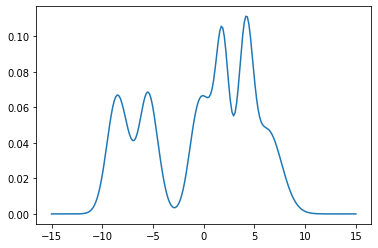

tensor(-284089.5625, grad_fn=<MulBackward0>)
tensor(0.0987)
denied


In [18]:
from IPython.display import clear_output
linspace = torch.linspace(-15.,15., 200)

current_model = DIFDensityEstimator(data, structure)
current_log_prob = -current_model.loss(data)*data.shape[0]
current_log_prob.backward()


for i in range(1,1000):
    tau = 0.005/(data.shape[0])
    clear_output(wait = True)
    plt.figure()
    sum_density = torch.exp(current_model.log_density(linspace.unsqueeze(-1)))
    plt.plot(linspace, sum_density.detach().numpy())
    plt.show()
    current_model, current_log_prob = metropolis_adjusted_langevin_step(current_model,current_log_prob, data, tau)
    